入念に整理してこちらを公開できるようにしよう。

「What IF」のChap 16 "Instrumental Variable Estimation"の発表に備えて、sampleデータ生成して操作変数法の説明をしてみました。

今、A（施策）のYへの効果を推定したいとする。
しかし、AとY両方に相関するUという変数のせいで、A,Y間の相関を因果として解釈できなくなってしまっている。

今回はUが観測できない時に、その交絡を調整しないでこの因果関係を推定する手法としてIV法というものを紹介する。

以下考える状況のDAGの一例
<img src="../img/IV.png">

<!-- ## 2SLS -->

<!-- 
$y = \mu + \alpha x + \epsilon$<br>
$x = \gamma + \pi z + v$

Regress y on z, then we get,
$\hat{\beta\pi} = \frac{\sum_i(z_i - \bar{z})(y_i - \bar{y})}{\sum_i(z_i - \bar{z})^2}$

This estimator is unbiased,
$E[\hat{\beta\pi}] = E[\frac{\sum_i(z_i - \bar{z})(y_i - \bar{y})}{\sum_i(z_i - \bar{z})^2}] = $
$\beta \pi + E[\frac{\sum_i(z_i - \bar{z})(\beta v + \epsilon)}{\sum_i(z_i - \bar{z})^2}] = \beta \pi$<br>
(The last equation is due to $Z \!\perp\!\!\!\perp \epsilon, v$)

Regress x on z, then we get,
$\hat{\pi} = \frac{\sum_i(z_i - \bar{z})(x_i - \bar{x})}{\sum_i(z_i - \bar{z})^2}$<br>

This estimator is also unbiased,
$E[\hat{\pi}] = E[\frac{\sum_i(z_i - \bar{z})(x_i - \bar{x})}{\sum_i(z_i - \bar{z})^2}] = $
$\pi + E[\frac{\sum_i(z_i - \bar{z})v}{\sum_i(z_i - \bar{z})^2}] = \pi$<br>
(The last equation is due to $Z \!\perp\!\!\!\perp v$)


Therefore we can get the estimated parameter $\hat{\beta}$, by divide $\hat{\beta\pi}$ by $\hat{\pi}$ -->

解説はTBD
<!-- 今、$\alpha, \beta$が各個人で不変の時を仮定している。

- ２変数のときを考えると、これはつまり、
    - $\alpha$:Treatment群に配置する事で実際に処置を受ける確率
    - $\beta$:処置を受けた事で状態が改善する確率
- と解釈する事ができる。

**もし、各個人で、実際に配置された時に、以下のように4つの行動パターンをとるグループがあるとしたら？**

- never-taker(N):配置されようがされまいが、処置を受けない
- complier(C):配置されるかぎりに置いて処置を受けない
- Always-taker(A):配置されようがされまいが、処置を受ける
- defier(D):配置されたら処置を受けず、配置されない場合処置を受ける。

--|X(Z=1)=1|X(Z=1)=0
--|--|--
X(Z=0)=1|AlwaysTaker|Defier
X(Z=1)=0|Complier|Never-taker

--|X=1|X=0
--|--|--
Z=1|A+C|N+D
Z=0|A+D|N+C

今回はこのケースで上の古典的操作変数法が正しく$\bar{\beta}$を推定できなくなる事を示します。 -->

In [18]:
import numpy as np

- 説明変数A,  操作変数Z,及び交絡変数Uを多変量正規分布$N(\mu, \Sigma)$から生成する
    - $\mu = [0.5, 1.5, 20.0]$
    - $\Sigma:$分散共分散行列、$Cov(Z, A) = 0.4,Cov(A, U) = -0.7, Cov(Z, U) = 0.0$を満たすと仮定する。
- 目的変数yは以下のように定式化されているとする。
    - $y = 2 A + 6U + \epsilon$ 
    - where $\epsilon \sim N(0, 1)$

In [19]:
Sigma = np.eye(3)
Sigma[1, 0] = -0.7
Sigma[0, 1] = -0.7
Sigma[2, 0] = 0.4
Sigma[0, 2] = 0.4
d = np.random.multivariate_normal([0.5, 1.5, 20.0], Sigma, size=10000)

In [20]:
Sigma

array([[ 1. , -0.7,  0.4],
       [-0.7,  1. ,  0. ],
       [ 0.4,  0. ,  1. ]])

In [21]:
e = np.random.randn(len(d))

In [22]:
X = d[:, 0]
u = d[:, 1]
Z = d[:, 2]

In [23]:
# 目的変数の真のモデル
# y = 2 A + 6U + \epsilon
y = X*2 + 6*u + e

In [24]:
import seaborn as sns

単純に(X, y)を可視化すると、負の相関関係がありそうに見えてしまう。

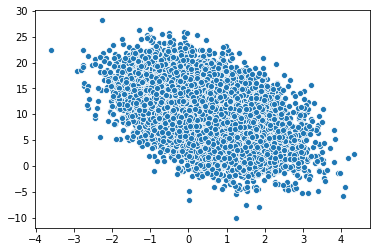

In [25]:
sns.scatterplot(x=X, y=y)

In [27]:
def ols(x, y):
    denom = np.mean((x - np.mean(x))**2)
    nomi = np.cov(X, y)[1, 0]
    return nomi/denom

In [28]:
#  ordinary least squares
print("単純にXでyを回帰すると", ols(X, y))
print("交絡要因を取り除いてあげると、", ols(X, y - 6*u))

単純にXでyを回帰すると -2.249917301523579
交絡要因を取り除いてあげると、 1.997859915706129


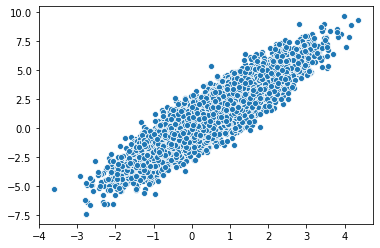

In [29]:
sns.scatterplot(x=X, y=y-6*u)

- ただ現実では、交絡Uは観測できないケースが多い&経済活動などの観察データでは、多数の交絡があることが予想される。
- そこで交絡調整を必要としない、「あるいくつかの仮定」を満たす操作変数というものを利用して推定する方法を試してみる。

In [30]:
def IV(x, y, z):
    denom = np.cov(X, z)[1, 0]
    nomi = np.cov(z, y)[1, 0]
    return nomi/denom

In [31]:
print("操作変数法を用いて推定した時の因果効果", IV(X, y, Z))

操作変数法を用いて推定した時の因果効果 1.9331223170128733


In [32]:
print("交絡要因を取り除いてあげて推定した因果効果、", ols(X, y - 6*u))

交絡要因を取り除いてあげて推定した因果効果、 1.997859915706129


## OLS推定量ではマイナスになっていたが、IV法を利用すると真のモデルと整合的な推定値を求めることができた。

- U関係なく動くZの変動を利用し、Zと相関するXの変動からYの変動を説明するということ。
- IVの式を確認すると、$\displaystyle \frac{Cov(Z, Y)}{Cov(Z, X)}$となっていることがわかる。

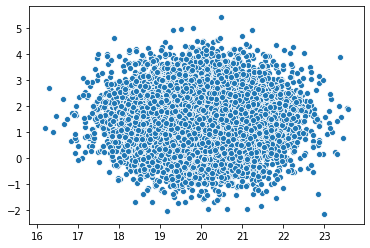

In [34]:
sns.scatterplot(x=Z, y=u)

In [ ]:
## Weak Instrumentのケースを紹介する（TBD）

In [ ]:
# Sigma = np.eye(4)
# Sigma[1, 0] = Sigma[0, 1] = 0.4
# Sigma[2, 0] = Sigma[0, 2] = 0.7
# Sigma[0, 3] = 0.5;Sigma[3, 0] = 0.5;Sigma[1, 3] = 0.5;Sigma[3, 1] = 0.5
# # X, y, IV, U
# data = np.random.multivariate_normal([0.5, 3, 0.5, 0.5], Sigma, size=10000)
# X = data[:, 0]
# y = data[:, 1]
# Z = data[:, 2]
# U = data[:,3]
# y[X>0].mean(), y[X<0].mean()
# np.corrcoef(y, (U> 0)*1, )